<a href="https://colab.research.google.com/github/keresztesbeata/Computer-Vision-Projects/blob/main/pattern_recognition/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBM (Restrictive Boltzmann Machine)

**Energy based model**

> Assigns lower energy values to more relevant features and higher energy values for less important features.

> **Objective**: minimize the energy value.


> **Restrictive**: because the neurons inside the same layer are not connected, but they are fully connected with the neurons in the next layer.

To find the optimal weight W, which minimizes the energy function E, we use **SGD**(Stochastic Gradient Descent). For this we need to compute the derivative of E with respect to v and h (visible and hidden neuron's input), which in turn gives us 2 terms, a positive and negative gradient. 

Positive phase increases the probability of the training data, while the negative decreases it.

To adjust the weights we use the "Contrastive Divergence" algorithm, which build an update matrix that allows to alter incrementally the value of W.
W_new = W + learning_rate * CD

The RBM is trained through several forward and backward passes until it is able to extract the most important features/patterns.
> * **Forward pass**: input processing
> * **Backward pass**: reconstruction


In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
class RBM():
  def __init__(self, nv, nh):
    """
    nv = nr of neurons in the visible layer
    nh = nr of neurons in the hidden layer
    """
    self.nv = nv
    self.nh = nh

    # initiliaze the weight matrix
    self.W = tf.Variable(tf.random.normal([self.nv, self.nh]))
    # bias for hidden layer (initialized with 0)
    self.hb = tf.Variable(np.zeros(self.nh).astype(np.float32))
    # bias for visible layer (initialized with 0)
    self.vb = tf.Variable(np.zeros(self.nv).astype(np.float32))

  def forward_pass(self, v):
    """
     forward pass: compute a sample hidden activation vector (h)
    """
    _h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    # compute probability using a relu function
    h = tf.nn.relu(tf.sign(_h - tf.random.uniform(tf.shape(_h))))
    return h

  def backward_pass(self, h):
    """
     backward pass: compute a sample visible activation vector (v)
    """
    _v = tf.nn.sigmoid(tf.matmul(h, tf.transpose(self.W)) + self.vb)
    # compute probability using a relu function
    v = tf.nn.relu(tf.sign(_v - tf.random.uniform(tf.shape(_v))))
    return v

  def prob_reconstructed(self, v):
    """
     compute the new probability vector based on the reconstructed input v
    """
    h = tf.nn.sigmoid(tf.matmul(v, self.W) + self.hb)
    return h

  def compute_gradients(self, v0, h0, v1, h1):
    # positive weight gradient
    w_pos_grad = tf.matmul(tf.transpose(v0), h0)
    # negative weight gradient
    w_neg_grad = tf.matmul(tf.transpose(v1), h1)
    return w_pos_grad, w_neg_grad

  def compute_CD(self, w_pos_grad, w_neg_grad):
    """
     compute the CD to maximize
    """
    CD = (w_pos_grad - w_neg_grad) / self.nv
    return CD

  def update(self, learning_rate, CD, v0, h0, v1, h1):
    self.W = self.W + learning_rate * CD
    self.vb = self.vb + learning_rate * tf.reduce_mean(v0 - v1, 0)
    self.hb = self.hb + learning_rate * tf.reduce_mean(h0 - h1, 0)

  def calculate_loss(self, v0, v1):
    """
    LMS(Least Mean Squared) error computed based on the original and reconstructed input. 
    """
    loss = tf.math.abs(v0 - v1)
    return tf.reduce_mean(loss * loss)

  def train(self, X, lr=0.01, batch_size=64, epochs=15):
      nr_inputs = X.shape[0]
      train_losses = []

      for epoch in range(1, epochs+1):
        epoch_loss = 0
        s = 0
        for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          v0 = X[i:i+batch_size].reshape(batch_size, -1)
          # forward pass: initial hidden prob vector based on the input v0
          h0 = self.forward_pass(v0)
          # backward pass: reconstruct the input
          v1 = self.backward_pass(h0)
          # compute the new hidden prob vector based on the reconstructed input
          h1 = self.prob_reconstructed(v1)
          # compute the 2 gradients
          w_pos_grad, w_neg_grad = self.compute_gradients(v0, h0, v1, h1)
          # calculate Constructive Divergence matrix
          CD = self.compute_CD(w_pos_grad, w_neg_grad)
          # update the weight matrix and the visible bias & hidden bias
          self.update(lr, CD, v0, h0, v1, h1)

          # calculate the loss comparing
          loss = self.calculate_loss(v0, v1)
          epoch_loss += loss
          s += 1
          train_losses.append(loss)

        print('Epoch: ', epoch, ', train loss:', end =" ")
        tf.print(epoch_loss/s)

      self.plot_loss(train_losses)

      return np.asarray(train_losses).mean()

  def reconstruct(self, s):
     # flatten the input into a 1D array
     v0 = np.reshape(s, (1,-1))
     # initial hidden prob vector based on the input v0
     h0 = self.forward_pass(v0)
     # reconstruct the input
     out = self.backward_pass(h0)
     # convert the output to the input's original shape
     out = out.numpy().reshape(s.shape)
     return out

  def test(self, X_test, batch_size=32):
      nr_inputs = X_test.shape[0]
      test_losses = []

      for i in range(0, nr_inputs - batch_size, batch_size):
          # extract the next batch of data (input to the visible nodes)
          v0 = X_test[i:i+batch_size].reshape(batch_size, -1)
          # forward pass: initial hidden prob vector based on the input v0
          h0 = self.forward_pass(v0)
          # backward pass: reconstruct the input
          v1 = self.backward_pass(h0)
          # compute the new hidden prob vector based on the reconstructed input
          h1 = self.prob_reconstructed(v1)

          # calculate the loss comparing
          loss = self.calculate_loss(v0, v1)
          test_losses.append(loss)

      self.plot_loss(test_losses)

      return np.asarray(test_losses).mean()

  def plot_loss(self, loss):
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss)
    plt.show()

In [125]:
def preprocess_input(x):
  # shuffle the data
  x = np.random.permutation(x)
  # normalize input values
  x = x / 255.0
  x = x.astype(np.float32)
  return x

In [126]:
# load and prepare the input dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = preprocess_input(x_train)
X_test = preprocess_input(x_test)

In [127]:
nv = X_train.shape[1] * X_train.shape[2]
nh = 100
rbm = RBM(nv, nh)

Epoch:  1 , train loss: 0.267907292
Epoch:  2 , train loss: 0.159957319
Epoch:  3 , train loss: 0.135921389
Epoch:  4 , train loss: 0.126233667
Epoch:  5 , train loss: 0.121668622
Epoch:  6 , train loss: 0.119175412
Epoch:  7 , train loss: 0.117835671
Epoch:  8 , train loss: 0.116979152
Epoch:  9 , train loss: 0.116476133
Epoch:  10 , train loss: 0.116006494
Epoch:  11 , train loss: 0.115666188
Epoch:  12 , train loss: 0.115325749
Epoch:  13 , train loss: 0.115061507
Epoch:  14 , train loss: 0.114702955
Epoch:  15 , train loss: 0.114397667


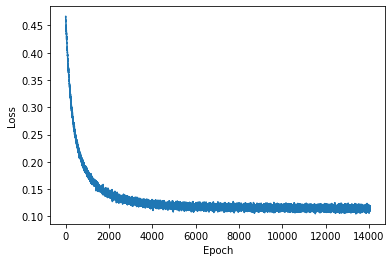

Train Error:  0.13155437
Train Accuracy:  0.868445634841919


In [128]:
# train the model
train_error = rbm.train(X_train)
print("Train Error: ", train_error)
print("Train Accuracy: ", 1 - train_error)

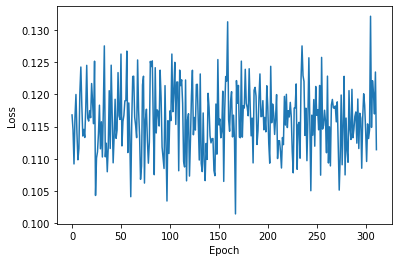

Test Error:  0.11608686
Test Accuracy:  0.8839131370186806


In [109]:
# test the model on the test set
test_error = rbm.test(X_test)
print("Test Error: ", test_error)
print("Test Accuracy: ", 1 - test_error)

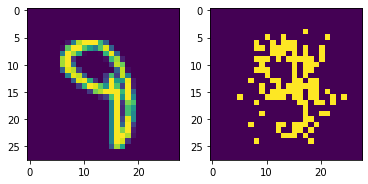

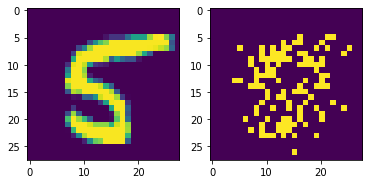

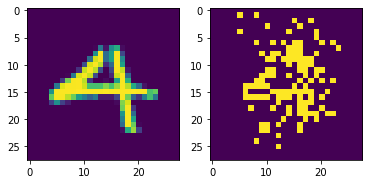

In [129]:
# verify the model on a few sample data from the test set
nr_samples = 3  
# generate nr_samples random indices
rand_indices = np.random.choice(X_test.shape[0], nr_samples, replace=False)

for i in range(0,nr_samples):
  sample_img = X_test[rand_indices[i]]
  output = rbm.reconstruct(sample_img)
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(sample_img)
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(output)